In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.11.0


In [4]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [12]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [13]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [14]:
dataset = dataset.dropna()

In [15]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'}) # map the origin column to a string

In [16]:
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='') # one-hot encode the origin column
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


In [17]:
train_dataset = dataset.sample(frac=0.8, random_state=0) # split the dataset into train and test sets (80% train, 20% test)
test_dataset = dataset.drop(train_dataset.index) # drop the train set from the original dataset

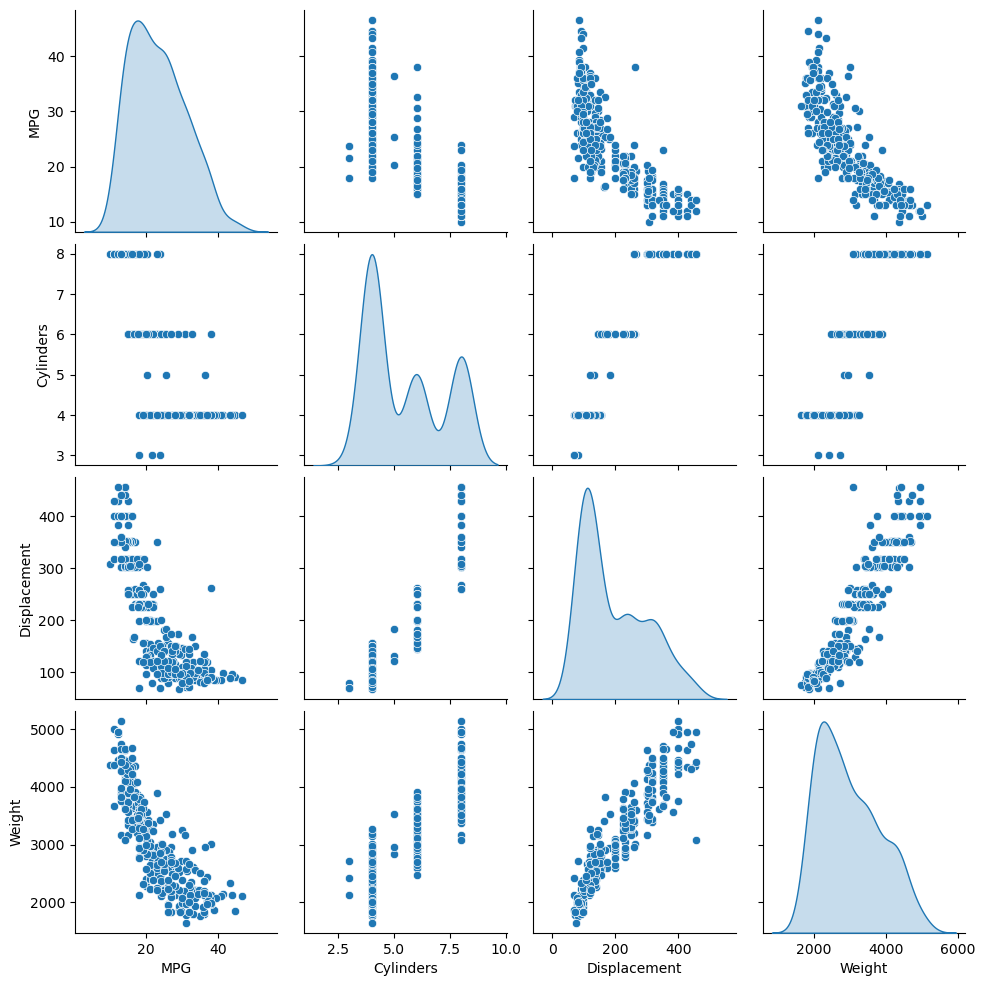

In [18]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde') # plot the distribution of each feature

In [19]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


In [22]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG') # remove the MPG column from the train and test sets
test_labels = test_features.pop('MPG') # this is the value we will train the model to predict

In [23]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Europe,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101


In [24]:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [66]:
normalizer.adapt(np.array(train_features)) # adapt the normalizer to the data

In [28]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


In [27]:
print(normalizer.mean.numpy())

[[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
     0.624]]


In [29]:
horsepower = np.array(train_features['Horsepower'])

horsepower_normalizer = layers.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)

In [30]:
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

horsepower_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [31]:
horsepower_model.predict(horsepower[:10])

1/1 [==============================] - 0s 118ms/step


array([[-0.056],
       [-0.031],
       [ 0.102],
       [-0.078],
       [-0.07 ],
       [-0.028],
       [-0.083],
       [-0.07 ],
       [-0.018],
       [-0.031]], dtype=float32)

In [32]:
horsepower_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [33]:
%%time
history = horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

f:\Users\Ray\anaconda3\lib\site-packages\keras\engine\data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


CPU times: total: 5.33 s
Wall time: 4.26 s


In [34]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.804137,4.185881,95
96,3.804447,4.196337,96
97,3.804528,4.177114,97
98,3.803522,4.193008,98
99,3.802494,4.187737,99


In [35]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10]) # set the y-axis range
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

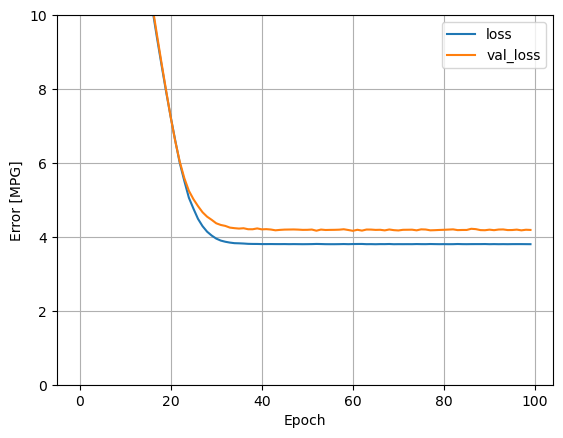

In [36]:
plot_loss(history)

In [37]:
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0)

In [39]:
x = tf.linspace(0.0, 250, 251) # create a range of values from 0 to 250 with 251 values in between
y = horsepower_model.predict(x)

8/8 [==============================] - 0s 4ms/step


In [40]:
def plot_horsepower(x, y):
  plt.scatter(train_features['Horsepower'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()


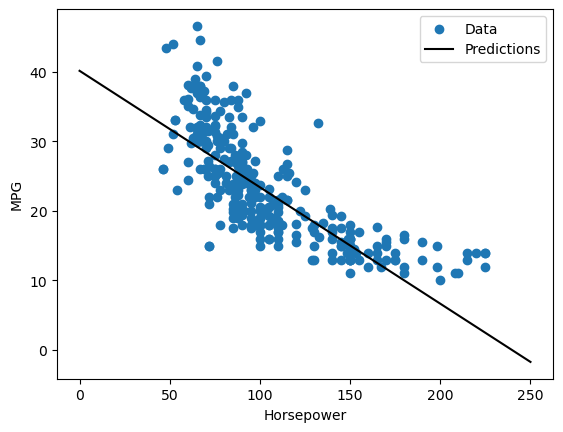

In [41]:
plot_horsepower(x, y)

In [42]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [43]:
linear_model.predict(train_features[:10])

1/1 [==============================] - 0s 61ms/step


array([[-0.315],
       [-0.102],
       [ 2.309],
       [-2.091],
       [-2.625],
       [ 0.236],
       [-2.666],
       [ 0.554],
       [ 0.973],
       [-0.642]], dtype=float32)

In [44]:
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[ 0.104],
       [-0.313],
       [ 0.387],
       [ 0.755],
       [ 0.573],
       [-0.757],
       [ 0.171],
       [-0.441],
       [ 0.291]], dtype=float32)>

In [45]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [49]:
#IPython magic command to time the execution of the cell

In [48]:
%%time  
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

f:\Users\Ray\anaconda3\lib\site-packages\keras\engine\data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


CPU times: total: 5.44 s
Wall time: 4.52 s


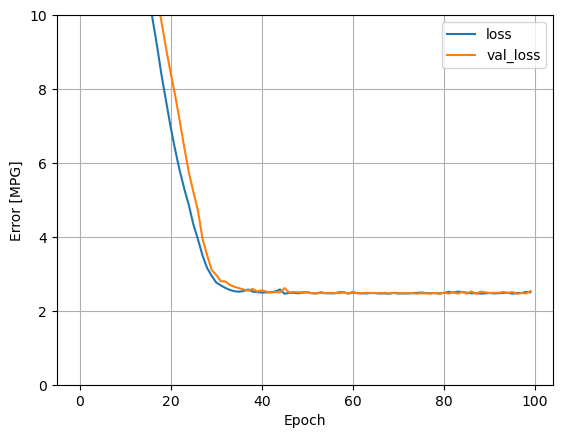

In [50]:
plot_loss(history)

In [51]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

In [56]:
def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])
    model.summary() # print a summary of the model
    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
    return model

In [57]:
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

#1 input + 2 hidden layers + 1 output layer = 4 layers
#1 input layer with 1 neuron
#2 hidden layers with 64 neurons each
#1 output layer with 1 neuron

# 1 + 1 + 1 = 3 parameters
# 1 * 64 + 64 = 128 parameters
# 64 * 64 + 64 = 4160 parameters
# 64 * 1 + 1 = 65 parameters

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_8 (Dense)             (None, 64)                128       
                                                                 
 dense_9 (Dense)             (None, 64)                4160      
                                                                 
 dense_10 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [58]:
%%time
history = dnn_horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

f:\Users\Ray\anaconda3\lib\site-packages\keras\engine\data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


CPU times: total: 6.31 s
Wall time: 5.12 s


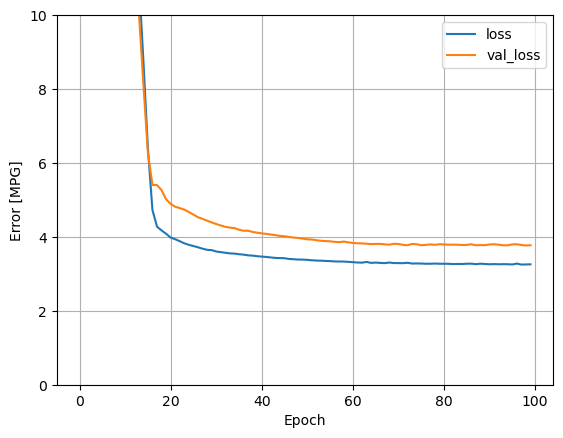

In [59]:
plot_loss(history)

In [60]:
x = tf.linspace(0.0, 250, 251) # create a range of values from 0 to 250 with 251 values in between
y = dnn_horsepower_model.predict(x)

8/8 [==============================] - 0s 1ms/step


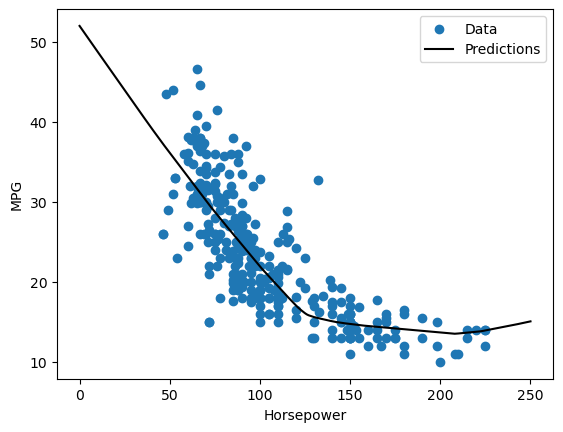

In [61]:
plot_horsepower(x, y)

In [63]:
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'], test_labels,
    verbose=0)

In [64]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

#1 input + 2 hidden layers + 1 output layer = 4 layers
#  1 + 9 + 9 = 19 parameters
#  9 * 64 + 64 = 640 parameters
#  64 * 64 + 64 = 4160 parameters

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 9)                19        
 n)                                                              
                                                                 
 dense_11 (Dense)            (None, 64)                640       
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                

In [69]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

f:\Users\Ray\anaconda3\lib\site-packages\keras\engine\data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


CPU times: total: 6.47 s
Wall time: 5.13 s


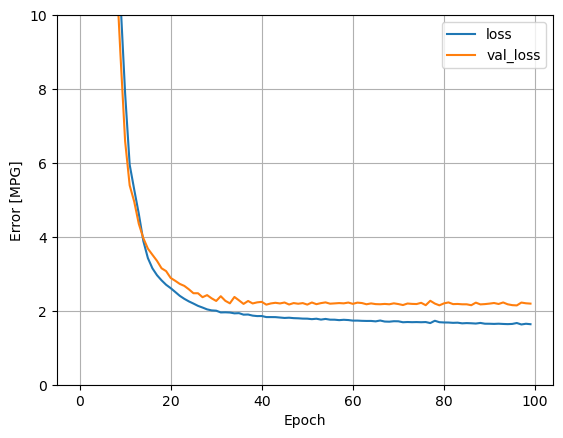

In [70]:
plot_loss(history)

In [73]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [74]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.646209
linear_model,2.587191
dnn_horsepower_model,2.932885
dnn_model,1.703886


3/3 [==============================] - 0s 1ms/step


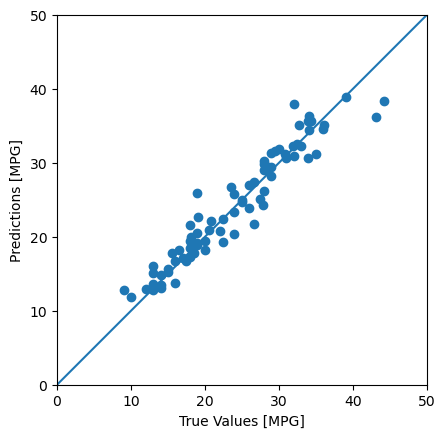

In [75]:
test_predictions = dnn_model.predict(test_features).flatten() # flatten the array to 1D array

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50] # set the x and y axis limits
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

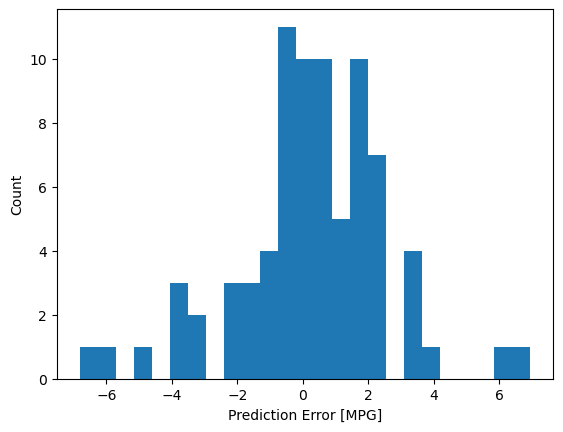

In [76]:
error = test_predictions - test_labels
#rror distribution: 
plt.hist(error, bins=25) # plot a histogram of the error, 25 bins
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

In [77]:
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model\assets


INFO:tensorflow:Assets written to: dnn_model\assets


In [78]:
reloaded = tf.keras.models.load_model('dnn_model')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)


In [79]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T # print the test results for all models in a table format

,Mean absolute error [MPG]
horsepower_model,3.646209
linear_model,2.587191
dnn_horsepower_model,2.932885
dnn_model,1.703886
reloaded,1.703886
